In [1]:
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/home/hice1/tpeat3/.conda/envs/cs7643-a2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda')
batch_size = 64
learning_rate = 0.001

# load datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

train_subset_size = int(0.1 * len(train_dataset))
train_subset, val_set = random_split(train_dataset, [train_subset_size, len(train_dataset) - train_subset_size])
train_subset_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()

In [3]:
class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [4]:
model = TwoLayerNN().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
from tqdm import tqdm

# one epoch
def train_epoch(model, dataloader, loss_function, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    loss_values = []  # To store loss values for each batch
    
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Training')
    
    for i, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_values.append(loss.item())

        progress_bar.set_postfix(loss=loss.item())
        
    average_loss = sum(loss_values) / len(loss_values)
    print(f"Epoch {epoch} finished, average loss: {average_loss:.4f}")
    
    return running_loss

def eval(model, test_loader, criterion, device):
    model.eval()

    # Visualize five outputs
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        fig = plt.figure(figsize=(10, 2))
        for idx in range(5):
            ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
            ax.imshow(images[idx].squeeze().cpu(), cmap='gray')
            ax.set_title(f"Predicted: {predicted[idx].cpu().item()}")
        plt.show()


    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')
    return accuracy, val_loss

In [6]:
# Training process
epochs = 5
for epoch in range(epochs):
    train_epoch(model, train_subset_loader, loss_fn, optimizer, device, epoch)

Training: 100%|██████████| 94/94 [00:04<00:00, 20.59it/s, loss=2.21]


Epoch 0 finished, average loss: 2.2656


Training: 100%|██████████| 94/94 [00:01<00:00, 75.40it/s, loss=2.15]


Epoch 1 finished, average loss: 2.1899


Training: 100%|██████████| 94/94 [00:01<00:00, 75.87it/s, loss=2.06]


Epoch 2 finished, average loss: 2.1201


Training: 100%|██████████| 94/94 [00:01<00:00, 76.01it/s, loss=2.06]


Epoch 3 finished, average loss: 2.0493


Training: 100%|██████████| 94/94 [00:01<00:00, 75.98it/s, loss=2.06]


Epoch 4 finished, average loss: 1.9777


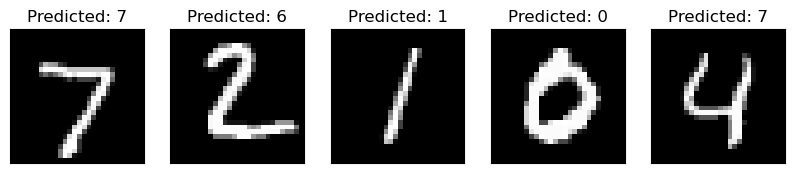

Accuracy on the test set: 51.56%


(51.5625, 124.62004089355469)

In [7]:
eval(model, test_loader, loss_fn, device)

# UNet to genMNIST

Before we generate weights let genearte MNIST straight up

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 2, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 2, stride=2, padding=1)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(64, 1, 2, stride=2)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        # Decoder
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        
        return x

In [9]:
unet = UNet().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(enumerate(train_subset_loader), total=len(train_subset_loader), desc='Training')
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        noisy_images = inputs + torch.randn_like(inputs).to(device) * 0.1  # Add noise to the input images
        predicted_images = unet(noisy_images)
        
        # Consistency models
        consistency_weight = 0.1
        noise_level = 0.2
        pred_noise = torch.randn_like(predicted_images).to(device)
        noisy_pred_images = predicted_images + pred_noise * noise_level
        pred_denoised_images = unet(noisy_pred_images)
        
        # Calculate the loss
        denoising_loss = criterion(predicted_images, inputs)
        consistency_loss = criterion(pred_denoised_images, predicted_images)
        loss = denoising_loss + consistency_weight * consistency_loss
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()

        pbar.set_postfix(loss=loss.item())
        
    # Print the average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Training: 100%|██████████| 94/94 [00:07<00:00, 13.40it/s, loss=0.0676]


Epoch 1/5, Loss: 0.0229


Training: 100%|██████████| 94/94 [00:01<00:00, 55.47it/s, loss=0.0412]


Epoch 2/5, Loss: 0.0051


Training: 100%|██████████| 94/94 [00:01<00:00, 55.58it/s, loss=0.0335]


Epoch 3/5, Loss: 0.0038


Training: 100%|██████████| 94/94 [00:01<00:00, 55.47it/s, loss=0.0299]


Epoch 4/5, Loss: 0.0033


Training: 100%|██████████| 94/94 [00:01<00:00, 55.63it/s, loss=0.0266]


Epoch 5/5, Loss: 0.0030


## Sample model

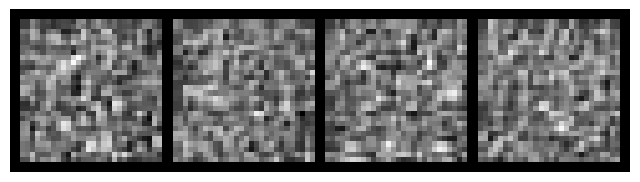

In [10]:
unet.eval()

noise = torch.randn(4, 1, 28, 28).to(device)

with torch.no_grad():
    generated_images = unet(noise)

generated_images = generated_images.view(-1, 1, 28, 28)

image_grid = make_grid(generated_images, nrow=4, padding=2, normalize=True)

image_grid_numpy = image_grid.permute(1, 2, 0).cpu().numpy()

# Display the image grid
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_numpy, cmap='gray')
plt.axis('off')
plt.show()

## How do we fix this garbage? Add timestep embeddings

In [15]:
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class UNet(nn.Module):
    def __init__(self, channel_dims=[32, 64, 128, 256], time_embed_dim=128):
        super(UNet, self).__init__()
        
        # Encoder
        s = 1
        in_dim = 1
        self.convs = nn.ModuleList()
        for i, out_dim in enumerate(channel_dims):
            self.convs.append(nn.Conv2d(in_dim, out_dim, 3, stride=s))
            in_dim = out_dim
            s = 2
        
        # Decoder
        in_dim = channel_dims[-1]
        s = 2
        self.upconvs = nn.ModuleList()
        for i, out_dim in enumerate(channel_dims[::-1]):
            out_pad = 0
            if i in [1, 2]:
                out_pad = 1
            if i == 3:
                s = 1
            
            self.upconvs.append(nn.ConvTranspose2d(in_dim, out_dim, 3, stride=s, output_padding=out_pad))
            in_dim = out_dim
        
        # encoder time embed
        self.encoder_dense = nn.ModuleList()
        for out_dim in channel_dims:
            self.encoder_dense.append(nn.Linear(time_embed_dim, out_dim))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Time embedding
        self.time_embed = GaussianFourierProjection(time_embed_dim)
        self.dense = nn.Linear(time_embed_dim, 32)
        
    def forward(self, x, t):
        # Embed time
        time_embed = self.time_embed(t)
        
        for i, conv in enumerate(self.convs):
            x = conv(x)
            if i == 0:
                y = self.dense(time_embed)
                y = y.unsqueeze(-1).unsqueeze(-1)
                x += y
            x = self.relu(x)
        
        # Decoder
        for upconv in self.upconvs:
            x = upconv(x)
        
        x = x / marginal_prob_std(t, sigma)[:, None, None, None]
        
        return x
    
def marginal_prob_std(t, sigma):
    """
    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)

In [17]:
model2 = UNet(time_embed_dim=256).to(device)
sigma=25

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    pbar = tqdm(enumerate(train_subset_loader), total=len(train_subset_loader), desc='Training')
    for i, (images, labels) in pbar:
        images = images.to(device)
        optimizer.zero_grad()
        
        time_steps = torch.rand(images.shape[0]).to(device)  # Random time steps between 0 and 1
        
        # pass in noisy image and time step
        pred_noise = torch.randn_like(images).to(device)
        noise_level = marginal_prob_std(time_steps, sigma)
        noisy_pred_images = images + pred_noise * noise_level[:, None, None, None]
        score = model2(noisy_pred_images, time_steps)
        
        # loss taken from consistency models
        loss = torch.mean(torch.sum((score * noise_level[:, None, None, None] + pred_noise)**2, dim=(1,2,3)))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        pbar.set_postfix(loss=loss.item())
        
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Training:   0%|          | 0/94 [00:00<?, ?it/s]/scratch/551306/ipykernel_115452/2131142911.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Training: 100%|██████████| 94/94 [00:01<00:00, 51.73it/s, loss=1.96e+4]


Epoch 1/10, Loss: 2249.3339


Training: 100%|██████████| 94/94 [00:01<00:00, 51.83it/s, loss=1.74e+4]


Epoch 2/10, Loss: 1861.0110


Training: 100%|██████████| 94/94 [00:01<00:00, 51.84it/s, loss=1.62e+4]


Epoch 3/10, Loss: 1690.7322


Training: 100%|██████████| 94/94 [00:01<00:00, 51.85it/s, loss=1.58e+4]


Epoch 4/10, Loss: 1593.9285


Training: 100%|██████████| 94/94 [00:01<00:00, 51.83it/s, loss=1.48e+4]


Epoch 5/10, Loss: 1537.6442


Training: 100%|██████████| 94/94 [00:01<00:00, 51.85it/s, loss=1.47e+4]


Epoch 6/10, Loss: 1502.2740


Training: 100%|██████████| 94/94 [00:01<00:00, 51.85it/s, loss=1.48e+4]


Epoch 7/10, Loss: 1472.2758


Training: 100%|██████████| 94/94 [00:01<00:00, 51.84it/s, loss=1.42e+4]


Epoch 8/10, Loss: 1448.8345


Training: 100%|██████████| 94/94 [00:01<00:00, 51.88it/s, loss=1.38e+4]


Epoch 9/10, Loss: 1431.6973


Training: 100%|██████████| 94/94 [00:01<00:00, 51.87it/s, loss=1.48e+4]

Epoch 10/10, Loss: 1419.1786


torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


/scratch/551306/ipykernel_115452/2131142911.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/scratch/551306/ipykernel_115452/2131142911.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


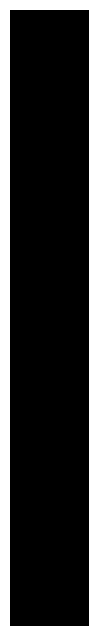

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


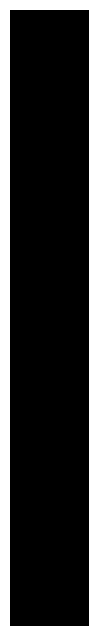

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


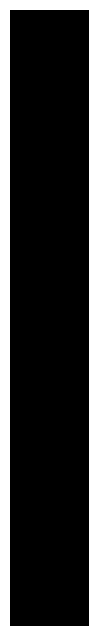

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


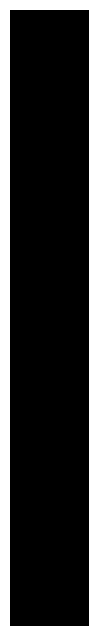

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


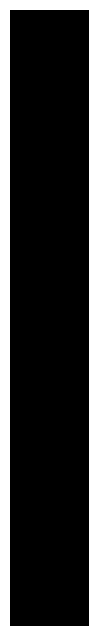

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


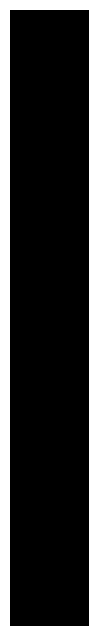

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


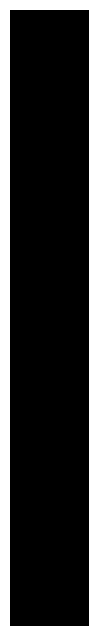

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


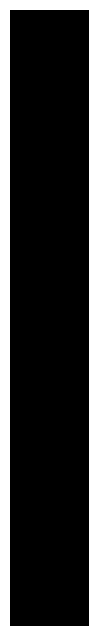

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


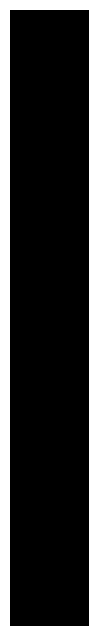

torch.Size([4, 32, 28, 28])
torch.Size([128, 1, 28, 28])


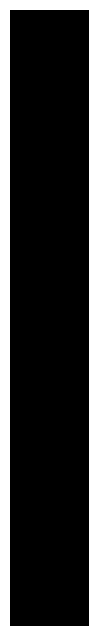

In [23]:
model2.eval()

bs = 4

time = torch.ones(bs).to(device)
noise = torch.randn(bs, 1, 28, 28).to(device) * marginal_prob_std(time, sigma)[:, None, None, None]

step_size = torch.tensor(10).to(device)
for step in range(0, 100, 10):
    
    with torch.no_grad():
        bs_time = time * step
        g = diffusion_coeff(bs_time, sigma)
        generated_images = model2(noise, bs_time)
        print(generated_images.shape)
#         mean_noise = noise + (g**2)[:, None, None, None] * generated_images * step_size
        # noise = mean_noise + g[:, None, None, None] * torch.randn_like(noise).to(device)
        
    # generated_images = mean_noise.clamp(0, 1)
    generated_images = generated_images.view(-1, 1, 28, 28)
    print(generated_images.shape)

    image_grid = make_grid(generated_images, nrow=4, padding=2, normalize=True)

    image_grid_numpy = image_grid.permute(1, 2, 0).cpu().numpy()

    # Display the image grid
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid_numpy, cmap='gray')
    plt.axis('off')
    plt.show()

## Closer; something wants to happen, just gotta push it there

In [140]:
from scipy import integrate

In [141]:
atol=1e-4
rtol=1e-5
z = None
eps=1e-6
dtype=torch.float32
noise = torch.randn(bs, 1, 28, 28).to(device) * marginal_prob_std(time, sigma)[:, None, None, None]
init_x = noise
shape = init_x.shape
init_x = torch.clamp(init_x, min=-1e5, max=1e5).to(torch.float32)
t = torch.ones(batch_size, device=device)

shape = init_x.shape
intermediate_samples = []
visualize=True

def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=dtype).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=dtype).reshape((sample.shape[0], ))
    with torch.no_grad():
        score = model2(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float32)

def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    if visualize:
        intermediate_samples.append(torch.tensor(x, device=device, dtype=dtype).reshape(shape))
    time_steps = torch.ones((shape[0],), device=device) * t
    g = diffusion_coeff(t, sigma).cpu().numpy()
    score = score_eval_wrapper(torch.tensor(x, device=device).reshape(shape), time_steps)
    return -0.5 * (g**2) * score

# Run the black-box ODE solver.
res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
print(f"Number of function evaluations: {res.nfev}")

x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

/scratch/550893/ipykernel_46240/885697660.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/scratch/550893/ipykernel_46240/108517298.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample, device=device, dtype=dtype).reshape(shape)
/scratch/550893/ipykernel_46240/108517298.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_steps = torch.tensor(time_steps, device=device, dtype=dtype).reshape((sample.shape[0], ))


ValueError: operands could not be broadcast together with shapes (100352,) (3136,) 

In [122]:
intermediate_samples[0].shape

torch.Size([4, 1, 28, 28])

In [123]:
def plot_intermediate(intermediate_samples, device='cuda', dtype=torch.float32):
    # 8 images to visualize
    num_visualization_timesteps = 8
    # selects evenly spaces images
    visualization_indices = np.linspace(0, len(intermediate_samples) - 1, num_visualization_timesteps, dtype=int)
    visualization_samples = [intermediate_samples[i] for i in visualization_indices]

    fig, axes = plt.subplots(1, 8, figsize=(20, 2.5))
    for i, ax in enumerate(axes):
        sample = torch.tensor(visualization_samples[i], device=device, dtype=dtype)
        sample = sample.clamp(0.0, 1.0)
        # necessary transform for cifar10
        sample = sample[0].permute(2, 1, 0).squeeze(0)
        # print(sample.shape)
        ax.imshow(sample.cpu().numpy(), vmin=0., vmax=1., cmap='gray')
        ax.axis('off')
    plt.show()

/scratch/550893/ipykernel_46240/972691376.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(visualization_samples[i], device=device, dtype=dtype)


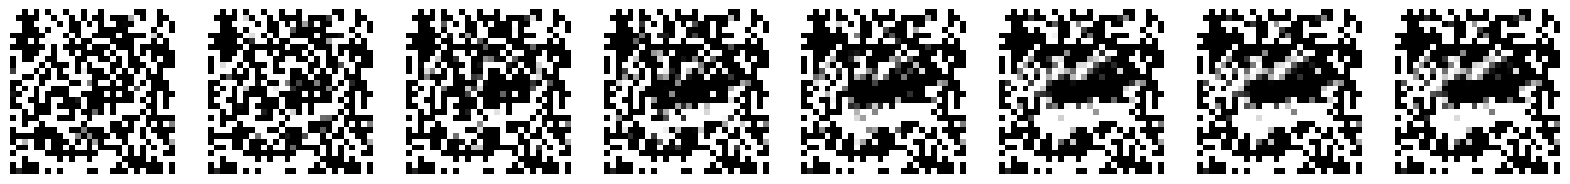

In [124]:
plot_intermediate(intermediate_samples)

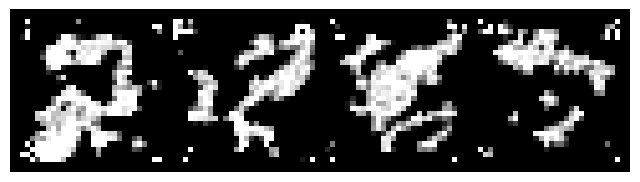

In [89]:
generated_images = x.clamp(0, 1)
generated_images = generated_images.view(-1, 1, 28, 28)

image_grid = make_grid(generated_images, nrow=4, padding=2, normalize=True)

image_grid_numpy = image_grid.permute(1, 2, 0).cpu().numpy()

# Display the image grid
plt.figure(figsize=(8, 8))
plt.imshow(image_grid_numpy, cmap='gray')
plt.axis('off')
plt.show()

In [17]:
model.fc1.weight.data.shape

AttributeError: 'UNet' object has no attribute 'fc1'

In [8]:
class SimpleUNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=512, kernel_size=3, padding=1):
        super(SimpleUNetGenerator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, padding=padding)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size, stride=2, padding=padding, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, out_channels, kernel_size, stride=2, padding=padding, output_padding=1)

        # Final layer
        self.final = nn.Linear(out_channels * 7 * 7, 512 * 784)

    def forward(self, x):
        # Encoder
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))

        # Decoder
        x = nn.functional.relu(self.deconv1(x))
        x = nn.functional.relu(self.deconv2(x))

        # Final layer
        x = x.view(-1, self.out_channels * 7 * 7)
        x = self.final(x)

        return x

In [9]:
fc_unet = SimpleUNetGenerator().to(device)
noise = torch.randn(1, 1, 28, 28).to(device)
weight_matrices = fc_unet(noise)
weight_matrices.shape

: 

In [13]:
class UNetGenerator(nn.Module):
    def __init__(self, input_size, output_size, num_channels=64):
        super(UNetGenerator, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_channels = num_channels

        # Encoder
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels * 2, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels * 2)
        self.conv3 = nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_channels * 4)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(num_channels * 4, num_channels * 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(num_channels * 2)
        self.deconv2 = nn.ConvTranspose2d(num_channels * 2, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(num_channels)
        self.deconv3 = nn.ConvTranspose2d(num_channels, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Decoder
        x = F.relu(self.bn4(self.deconv1(x)))
        x = F.relu(self.bn5(self.deconv2(x)))
        x = torch.sigmoid(self.deconv3(x))

        return x

In [14]:
def apply_weights_from_unet(two_layer_nn, unet_model, input_tensor):
    with torch.no_grad():
        weight_tensors = unet_model(input_tensor)

        # Flatten the UNet output to a 1D tensor
        weight_tensors = weight_tensors.view(-1)
        total_elements_needed = 512*28*28 + 512 + 512*10 + 10

        # Check if the UNet output has the correct total number of elements
        assert weight_tensors.numel() == total_elements_needed, f"UNet output has {weight_tensors.numel()} elements but {total_elements_needed} elements are needed."

        # Split the tensor into the respective shapes for fc1 weights, fc1 biases, fc2 weights, and fc2 biases
        fc1_weight, fc1_bias, fc2_weight, fc2_bias = torch.split(weight_tensors, [512*28*28, 512, 512*10, 10])

        # Reshape and assign the weights and biases to TwoLayerNN
        two_layer_nn.fc1.weight = nn.Parameter(fc1_weight.reshape(512, 28*28))
        two_layer_nn.fc1.bias = nn.Parameter(fc1_bias.reshape(512))
        two_layer_nn.fc2.weight = nn.Parameter(fc2_weight.reshape(10, 512))
        two_layer_nn.fc2.bias = nn.Parameter(fc2_bias.reshape(10))

In [15]:
input_size = (1, 1, 28, 28)  # Input shape for the U-Net generator
output_size = (512 * 28 * 28)  # Output shape for the weight matrices

unet_generator = UNetGenerator(input_size, output_size)

In [17]:
noise = torch.randn(1, 1, 28, 28)
weight_matrices = unet_generator(noise)
weight_matrices.shape

torch.Size([1, 1, 28, 28])

In [54]:
noise = torch.randn(1, 1, 28, 28)
weight_matrices = unet_generator(noise)
weight_matrices = weight_matrices.view(-1)

# Load the generated weight matrices into the TwoLayerNN model
model = TwoLayerNN()

# Get the actual sizes of the weight and bias tensors
fc1_weight_size = model.fc1.weight.numel()
fc1_bias_size = model.fc1.bias.numel()
fc2_weight_size = model.fc2.weight.numel()
fc2_bias_size = model.fc2.bias.numel()

# Calculate the slicing indices dynamically
fc1_weight_indices = slice(0, fc1_weight_size)
fc1_bias_indices = slice(fc1_weight_indices.stop, fc1_weight_indices.stop + fc1_bias_size)
fc2_weight_indices = slice(fc1_bias_indices.stop, fc1_bias_indices.stop + fc2_weight_size)
fc2_bias_indices = slice(fc2_weight_indices.stop, fc2_weight_indices.stop + fc2_bias_size)

# Create the state dictionary
state_dict = {
    "fc1.weight": weight_matrices[fc1_weight_indices].view(model.fc1.weight.shape),
    "fc1.bias": weight_matrices[fc1_bias_indices].view(model.fc1.bias.shape),
    "fc2.weight": weight_matrices[fc2_weight_indices].view(model.fc2.weight.shape),
    "fc2.bias": weight_matrices[fc2_bias_indices].view(model.fc2.bias.shape),
}

model.load_state_dict(state_dict)

RuntimeError: shape '[512, 784]' is invalid for input of size 784

In [37]:
unet = UNet()
unet_optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate)

In [39]:
## training unet
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        # Generate weights and biases for TwoLayerNN using UNet
        unet_optimizer.zero_grad()
        # input_tensor = images.unsqueeze(1)  # Adjust input tensor shape if necessary for UNet
        apply_weights_from_unet(two_layer_nn, unet, input_tensor)

        # Compute the prediction loss with the current weights
        predictions = two_layer_nn(images)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(predictions, labels)

        # Backpropagate the loss through TwoLayerNN and UNet
        loss.backward()
        unet_optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 1, 1, 28, 28]